# Libraries importing

In [13]:
from scipy.stats import randint
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Data loading and columns selection

In [2]:
selected_columns = ['age', 'stroke', 'hypertension', 'heart_disease', 'avg_glucose_level', 'ever_married', 'work_type',  'smoking_status',]

df = pd.read_csv('data/processed_data.csv')
df = df[selected_columns]

df_naive = pd.read_csv('data/processed_data_copy.csv')
df.head()

,age,stroke,hypertension,heart_disease,avg_glucose_level,ever_married,work_type,smoking_status
0,6.0,1,0,1,0.594096,1,2,1
1,5.0,1,0,0,0.594096,1,3,2
2,7.0,1,0,1,0.583954,1,2,2
3,4.0,1,0,0,0.594096,1,2,3
4,7.0,1,1,0,0.594096,1,3,2


# Data splitting

In [3]:
x = df.drop('stroke', axis=1)
y = df['stroke']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_naive = df_naive.drop('stroke', axis=1)
y_naive = df_naive['stroke']
x_train_naive, x_test_naive, y_train_naive, y_test_naive = train_test_split(x_naive, y_naive, test_size=0.2)

# Decision Tree Model

In [4]:
model = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=30)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.96      0.78      0.86       968
           1       0.10      0.44      0.16        54

    accuracy                           0.76      1022
   macro avg       0.53      0.61      0.51      1022
weighted avg       0.92      0.76      0.82      1022



# Decision Tree Visualization

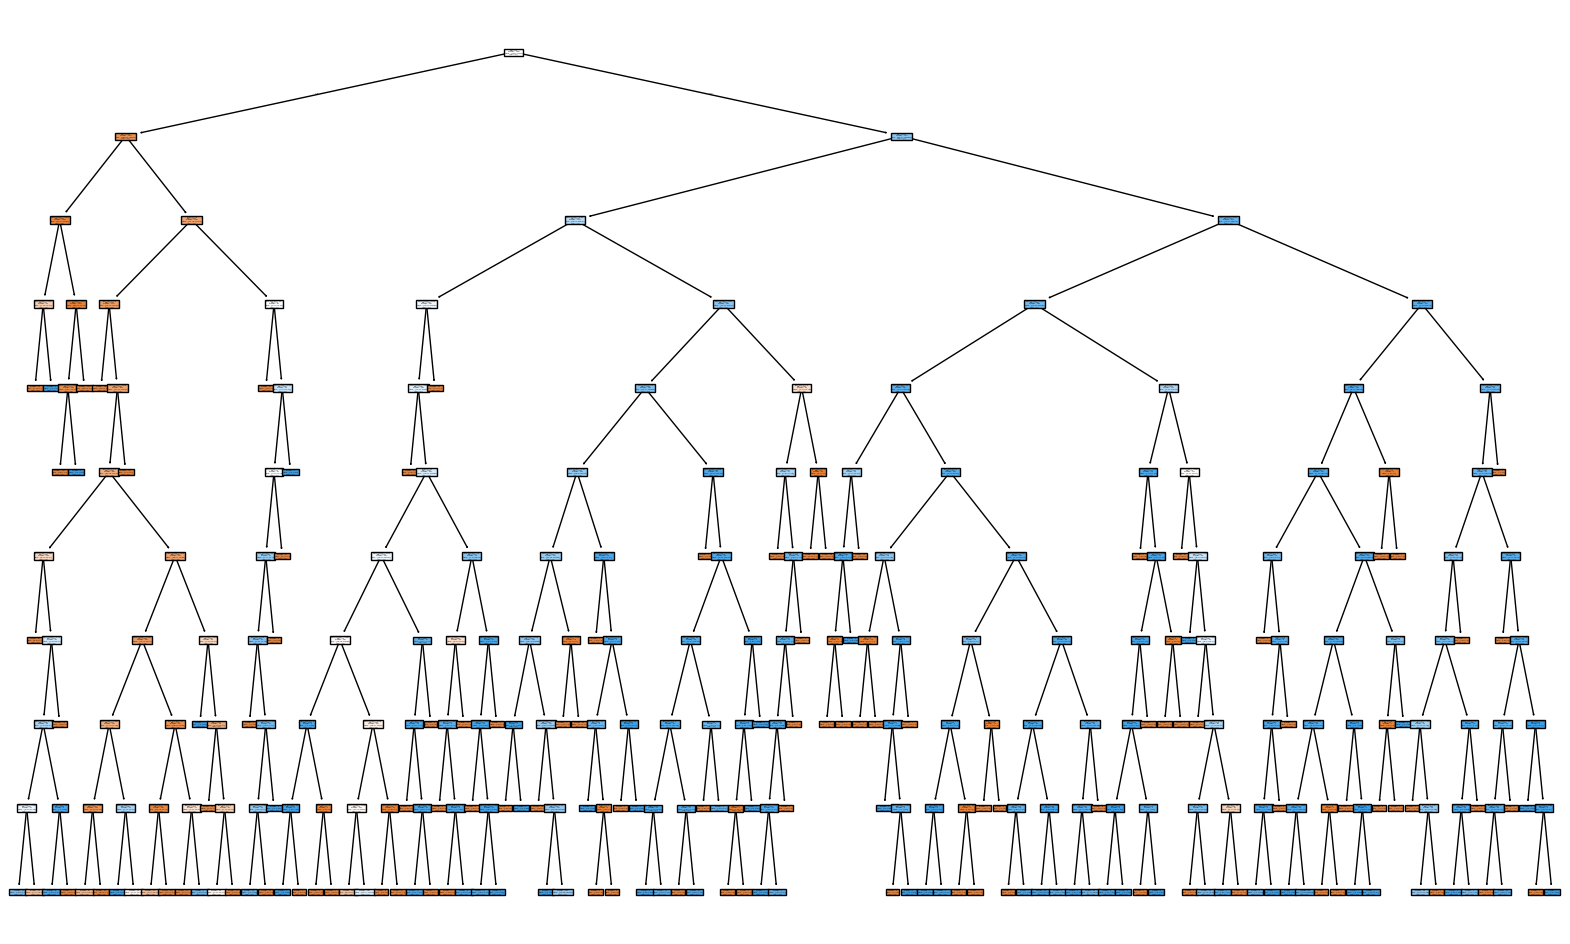

In [5]:
plt.figure(figsize=(20, 12))
plot_tree(model, filled=True, feature_names=selected_columns, class_names=True)
plt.savefig('tree.png')
plt.show()

# Random Forest Model

In [6]:
RF_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=30, min_samples_split= 5, min_samples_leaf=1 )
RF_model.fit(x_train, y_train)
RF_predictions = RF_model.predict(x_test)
print(classification_report(y_test, RF_predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       968
           1       0.33      0.06      0.10        54

    accuracy                           0.94      1022
   macro avg       0.64      0.52      0.53      1022
weighted avg       0.92      0.94      0.92      1022



# Hyperparameter Tuning for Random Forest

In [ ]:
# # Define a parameter grid for tuning
# param_grid = {
#     'n_estimators': [ 300,400,500,1000],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }
#
# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=RF_model,
#     param_grid=param_grid,
#     cv=4,                 # 4-fold cross-validation
#     n_jobs=-1,            # use all CPU cores
#     verbose=2,
#     scoring='f1'
# )
#
# # Run grid search
# grid_search.fit(x_train, y_train)
#
# # Best parameters and model
# print("Best Parameters:", grid_search.best_params_)
# print("Best CV Score:", grid_search.best_score_)
#
# # Evaluate on test set
# best_model = grid_search.best_estimator_
# test_score = best_model.score(x_test, y_test)
# print("Test Set Accuracy:", test_score)

# KNN Classifier

In [7]:
knclassifier = KNeighborsClassifier( n_neighbors=11, leaf_size=45, p=1, weights='uniform')
knclassifier.fit(x_train, y_train)
knn_predictions = knclassifier.predict(x_test)
print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       0.00      0.00      0.00        54

    accuracy                           0.95      1022
   macro avg       0.47      0.50      0.49      1022
weighted avg       0.90      0.95      0.92      1022



/home/adham/Documents/stroke-prediction/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/adham/Documents/stroke-prediction/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/adham/Documents/stroke-prediction/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [8]:
param_dist = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': randint(10, 60)
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=knclassifier,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=30
)

random_search.fit(x_train, y_train)


print("Best Params:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


y_pred = random_search.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Traceback (most recent call last):
  File "/home/adham/Documents/stroke-prediction/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzcwNTMyXzZlMTA0NGVjNjUwMjQ0NTU5Y2E4ODhkNTcyODMwNGQ2X2ZkNTljODIxZWM2ODQ3ZGNhODQzMmRmNWI4MTYyOTI2"}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/adham/Documents/stroke-prediction/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNzA1MzItaV8zOWJtYmg="}). Resource type should be one of 

Best Params: {'leaf_size': 48, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
Best Score: 0.9522880237495996
Test Accuracy: 0.9471624266144814


Traceback (most recent call last):
  File "/home/adham/Documents/stroke-prediction/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzcwNTMyXzZlMTA0NGVjNjUwMjQ0NTU5Y2E4ODhkNTcyODMwNGQ2X2QxMzdmNTE3Y2NhNTQ3YWE5NGJiMDEzZjZlOTZjMjUw"}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']


# Naive Bayes Classifier

In [9]:
nbclassifier = GaussianNB()
nbclassifier.fit(x_train_naive, y_train_naive)
nb_predictions = nbclassifier.predict(x_test_naive)
print(classification_report(y_test, nb_predictions))


              precision    recall  f1-score   support

           0       0.95      0.89      0.92       968
           1       0.07      0.15      0.10        54

    accuracy                           0.86      1022
   macro avg       0.51      0.52      0.51      1022
weighted avg       0.90      0.86      0.88      1022



## Confusion Matrix

/home/adham/Documents/stroke-prediction/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


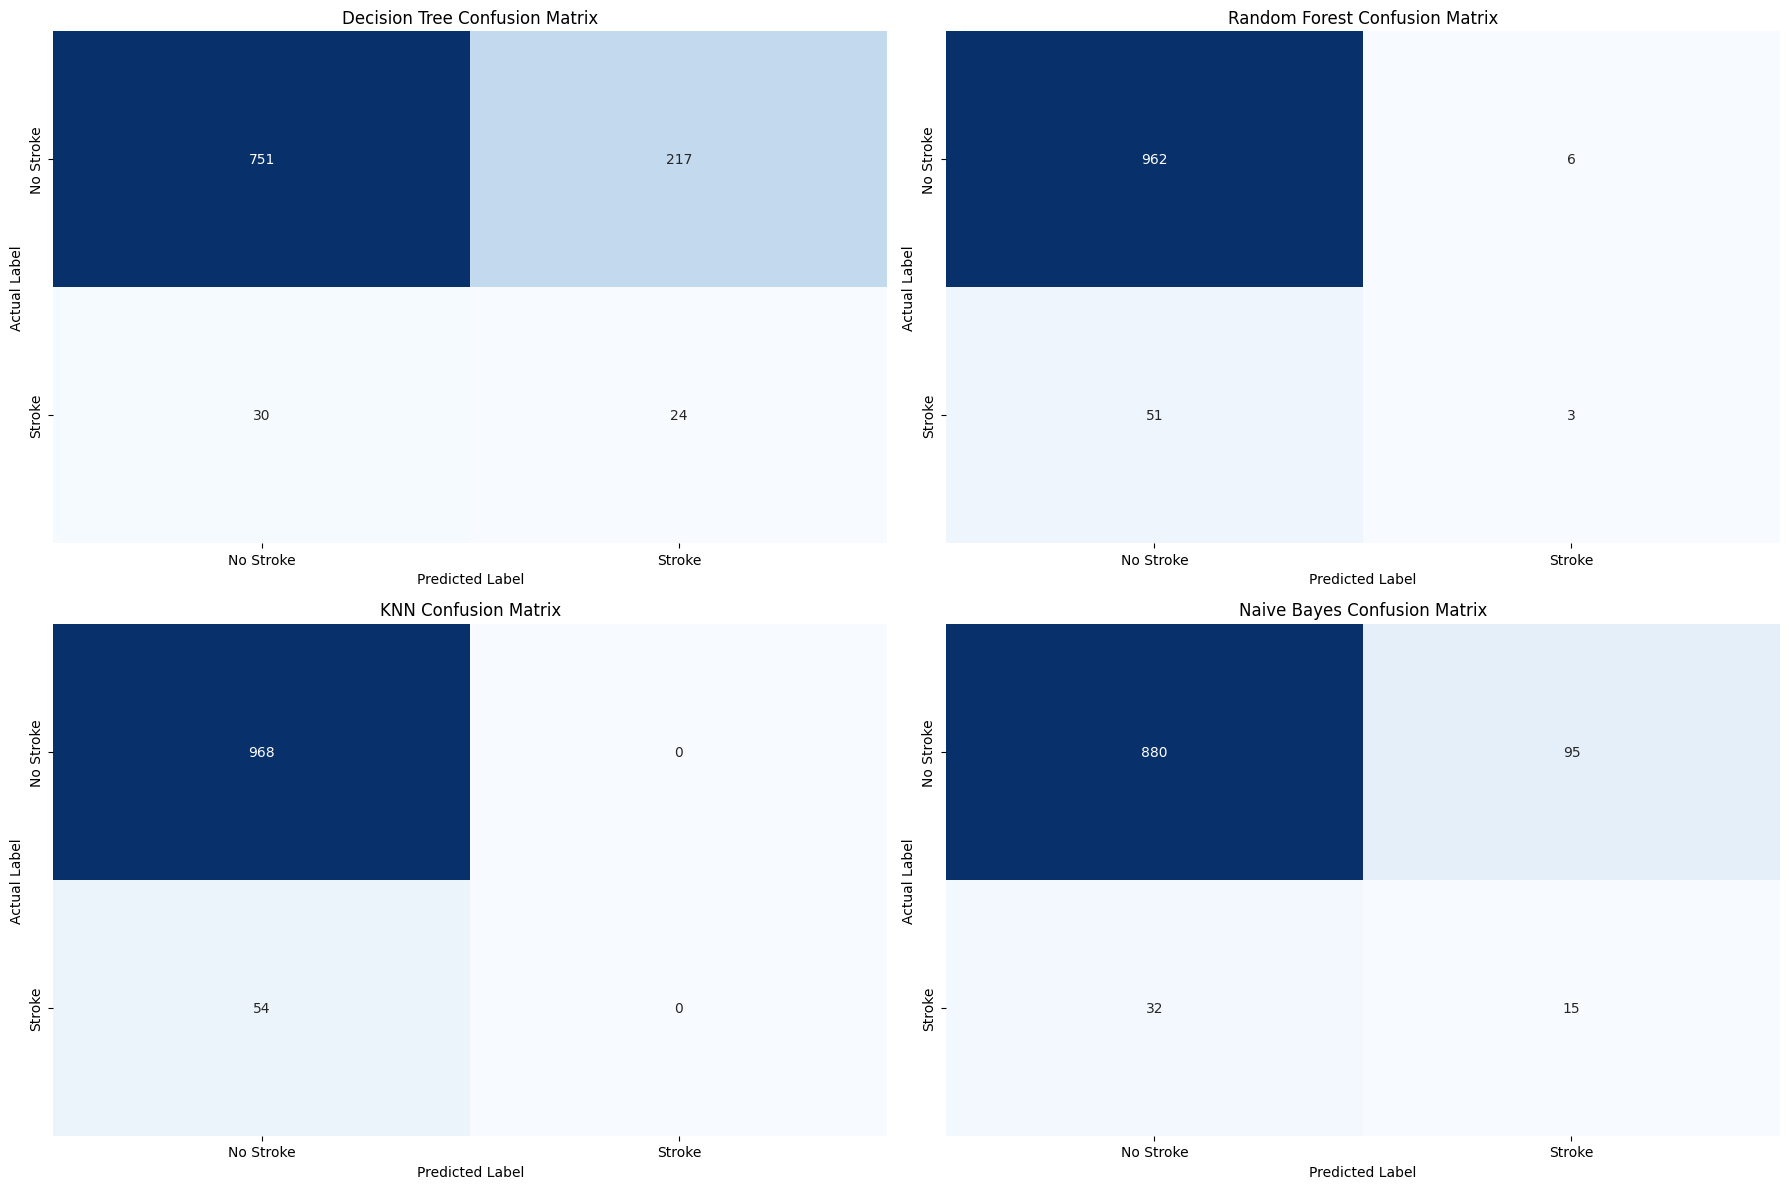


--- Performance Metrics for Predicting Stroke (Class 1) ---
           Model  Accuracy  Stroke Precision  Stroke Recall  Stroke F1
0  Decision Tree     0.758             0.100          0.444      0.163
3    Naive Bayes     0.876             0.136          0.319      0.191
1  Random Forest     0.944             0.333          0.056      0.095
2            KNN     0.947             0.000          0.000      0.000


In [ ]:
model_data = {
    "Decision Tree": (y_test, predictions),
    "Random Forest": (y_test, RF_predictions),
    "KNN": (y_test, knn_predictions),
    "Naive Bayes": (y_test_naive, nb_predictions)
}

performance_summary = []

plt.figure(figsize=(18, 12))

for i, (name, (true_y, pred_y)) in enumerate(model_data.items(), 1):
   
    cm = confusion_matrix(true_y, pred_y)
    
    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    
    acc = accuracy_score(true_y, pred_y)
   
    prec, rec, f1, _ = precision_recall_fscore_support(true_y, pred_y, average=None, labels=[0, 1])
    
    performance_summary.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Stroke Precision": round(prec[1], 3), 
        "Stroke Recall": round(rec[1], 3),    
        "Stroke F1": round(f1[1], 3)         
    })

plt.tight_layout()
plt.show()

# Performance Table
print("\n Performance Metrics for Predicting Stroke")
metrics_df = pd.DataFrame(performance_summary)
metrics_df.sort_values(by='Stroke Recall', ascending=False, inplace=True)
print(metrics_df)

## Feature Importance


--- Vital Parameters (Feature Importance) ---


/tmp/ipykernel_70532/3524592475.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


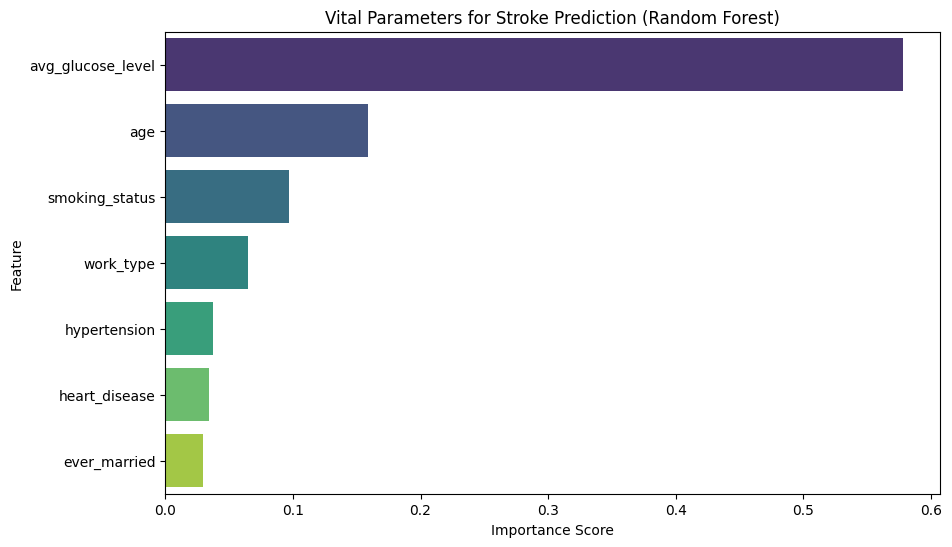

Most Vital Parameters:
          Feature  Importance
avg_glucose_level    0.578299
              age    0.158655
   smoking_status    0.096898


In [ ]:
print("\n--- Vital Parameters (Feature Importance) ---")

# Use Random Forest 
if hasattr(RF_model, 'feature_importances_'):
    
    features = x.columns
    importances = RF_model.feature_importances_
    
    feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
    plt.title('Vital Parameters for Stroke Prediction (Random Forest)')
    plt.xlabel('Importance Score')
    plt.show()
    
    print("Most Vital Parameters:")
    print(feat_df.head(3).to_string(index=False))
else:
    print("Feature  not supported")
